<a href="https://colab.research.google.com/github/MUmairAB/Breast-Cancer-Detection-using-CNNs-in-TensorFlow/blob/main/Breast_Cancer_Classification_with_CNNs_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Classification with CNNs in TensorFlow

**Created by Umair Akram**

This project uses Convolutional Neural Network (CNN) for Breast Cancer detection (a classification problem). 

## Stats about breast cancer

According to the World Health Organization (WHO), in 2020 alone, there were [2.3 million](https://www.who.int/news-room/fact-sheets/detail/breast-cancer) reported cases of breast cancer among women, resulting in **685,000** deaths worldwide. By the end of the same year, there were approximately **7.8 million** women who had been diagnosed with breast cancer within the past five years, establishing it as the most prevalent form of cancer globally.

Worldwide, female breast cancer is the [fifth](https://www.cancer.net/cancer-types/breast-cancer/statistics#:~:text=It%20is%20estimated%20that%2043%2C700,world%20died%20from%20breast%20cancer.) leading cause of death. 

## Introduction


As stated by [Pamela Wright](https://www.hopkinsmedicine.org/health/conditions-and-diseases/breast-cancer/invasive-ductal-carcinoma-idc), the medical director of the Breast Center at Johns Hopkins, **Invasive Ductal Carcinoma** (**IDC**), also referred to as **infiltrating ductal carcinoma**, is the predominant type of breast cancer. It represents 80% of all breast cancer diagnoses. For further information about IDC, please refer to this [article](https://www.breastcancer.org/types/invasive-ductal-carcinoma). In the context of this project, we have developed a classification model based on Convolutional Neural Networks (CNNs) using TensorFlow. The model utilizes **Histopathology Images** of patients to classify whether they have breast cancer or not!

## Dataset
We are using the dataset from Kaggle. It can be accessed [here](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/code?datasetId=7415&sortBy=voteCount). Following are some of the properties of this dataset:

The initial dataset comprised 162 slide images of breast cancer specimens scanned at a magnification of 40x. Due to their large dimensions, 277,524 patches measuring 50×50 pixels were extracted from these images to improve their manageability. These patches encompass the regions that contain Invasive Ductal Carcinoma (IDC), thereby enabling more efficient processing and analysis.

* 198,738 negative examples (i.e., no breast cancer)
* 78,786 positive examples (i.e., indicating breast cancer)

The dataset assigns a unique filename structure to each image, like:
```
u_xX_yY_classC.png 

```
For example:
```
10253_idx5_x1351_y1101_class0.png
```

- "u" is patient id
- "u" is the patient ID (10253_idx5), 
- "X" is the x-coordinate of where this patch was cropped from, 
- "Y" is the y-coordinate of where this patch was cropped from, and 
- "C" indicates the class where 0 is non-IDC and 1 is IDC. 

In [1]:
#Import necessary libraries
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

import os, shutil, pathlib, glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import random
SEED = 4747
random.seed(SEED)

### Load dataset from Kaggle

To download the dataset directly from Kaggle, we will use the **kaggle** API. For that we need to upload the **kaggle.json** file from our Kaggle account.

In [2]:
#Upload the "kaggle.jason" file using upload widget
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadumairab","key":"07533bcdc4f1d6b8fe1c3848e5dc5a45"}'}

In [3]:
#Create "~/.kaggle" directory
!mkdir ~/.kaggle

#Move "kaggle.json" file to this directory
!mv kaggle.json ~/.kaggle/

#Change the file access rights to the current user only
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Download the dataset with API command
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 3.07G/3.10G [00:23<00:00, 281MB/s]
100% 3.10G/3.10G [00:23<00:00, 141MB/s]


In [5]:
#List all the files
!ls

breast-histopathology-images.zip  sample_data


In [6]:
#Create a directory "dataset" to unzip the file there
!mkdir dataset

In [7]:
#List all the files
!ls

breast-histopathology-images.zip  dataset  sample_data


In [8]:
#Unzip the dataset quitely using "qq" flag 
# to the "dataset" directory using "d" flag
!unzip -qq "/content/breast-histopathology-images.zip" -d "/content/dataset"

## EDA

In [9]:
#Total directories (that is, total number of patients)
dirs = os.listdir("/content/dataset/")
print("Total number of directories are =",len(dirs))

Total number of directories are = 280


The last directory **"IDC_regular_ps50_idx5"** is duplicate and has different directory structure. So, we'll remove that from our list.

In [10]:
dirs.remove("IDC_regular_ps50_idx5")
print(print("Total number of directories are =",len(dirs)))

Total number of directories are = 279
None


In [11]:
"""
This functions accepts the class value of either:
      - "0": for normal tissues
      - "1": for cancer tissues 
and plots 49 random Histopathological images of that class.
"""

def plot_random_patches(clas):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for ax in axes.flatten():
        #Get a random patient id
        patient_id = random.choice(dirs)
        
        path = f"/content/dataset/{patient_id}/{clas}/*.png"
        #Read all the files' path present in "path" directory
        paths = glob.glob(path)
        #Select a random file path
        p = random.choice(paths)
        #Get the path with semantics appropriate for underlying OS
        p = pathlib.Path(p)
        #Load the image
        img = load_img(p)
        #Plot theimage
        ax.imshow(img)
        #Set image properties
        ax.set_title(label=patient_id, fontdict={"fontsize":8})
        ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        
    #Use different image title for cancer and normal tissues
    if clas == 1:
        fig.suptitle('IDC+ patches\n(Cancer tissues)', fontsize=16)
    else:
        fig.suptitle('IDC- patches\n(Noraml tissues)', fontsize=16)

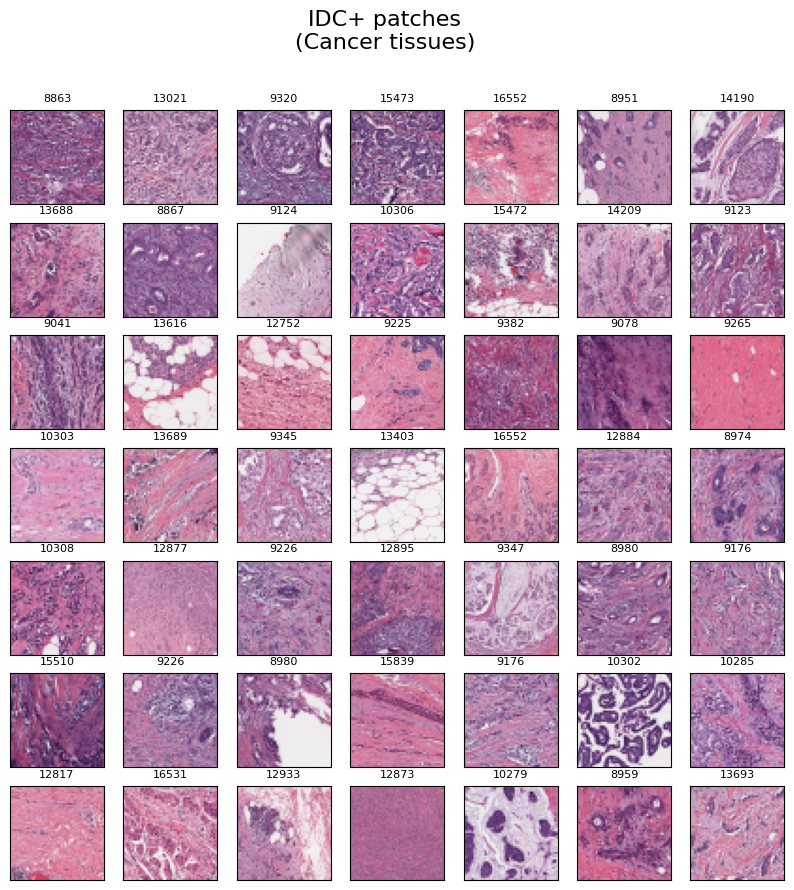

In [12]:
#Plot random images of IDC+ / cancer tissues
plot_random_patches(clas=1)

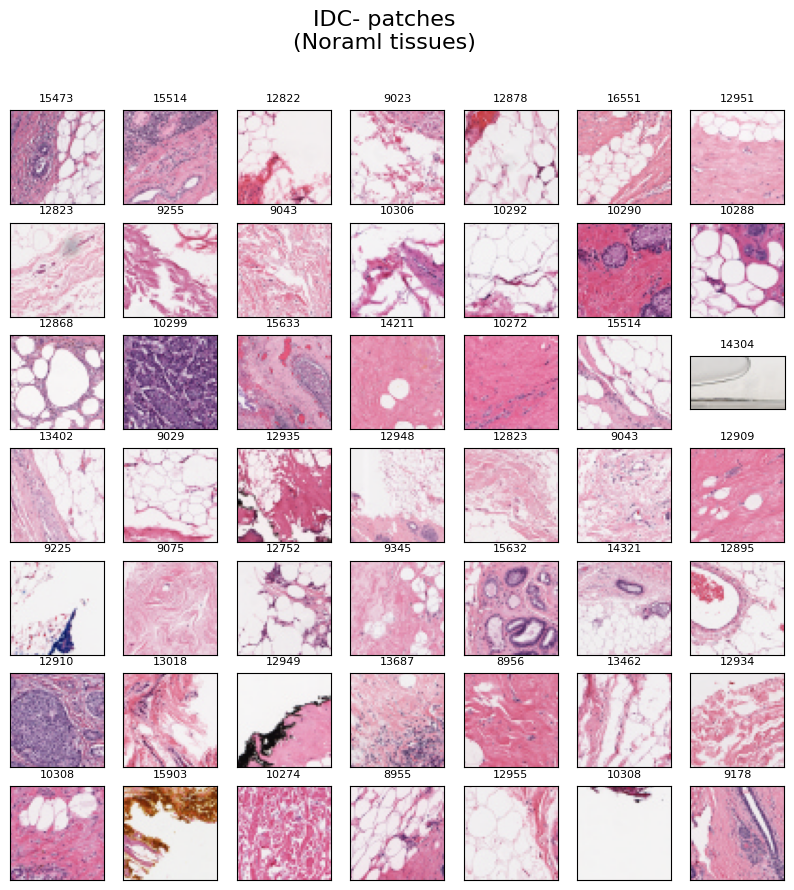

In [13]:
#Plot random images of IDC- / noraml tissues
plot_random_patches(clas=0)

In [14]:
"""
This function accepts the "patient id" as argument and returns a DataFrame 
that has following 4 columns:
 1) "x":      x-coordinate of where this image patch was cropped from
 2) "y":      y-coordinate of where this image patch was cropped from
 3) "class":  The class to which the image patch belongs
 4) "path":   Path of each image patch in the directory
"""

def convert_patient_metadata_to_df(patient_id):
    #Create a DataFrame "xy" to store the patient metadata    
    xy = pd.DataFrame(data=None, columns = ['x','y','class','path'])
    #Create an "index" variable to querry DataFrame "xy"
    index = 0
    for clas in [0,1]:
        #Get the list of paths to the all patch images of a certain patient
        paths = glob.glob(f"/content/dataset/{patient_id}/{clas}/*.png")
        for path in paths:
            #Since the image name contains the required information as explained
            #in the dataset description, we'll split the path string
            # and store the required values
            p = path.split("_")
            xy.loc[index,"x"] = int(p[2][1:])
            xy.loc[index,'y'] = int(p[3][1:])
            xy.loc[index,"class"] = int(p[4][5])
            xy.loc[index,"path"] = path
            #Increment the index
            index+=1
    #Return the DataFrame "xy" containing the required information
    #about a certain patient
    return xy

In [15]:
"""
This function accepts the "patient id" as argument and returns:
 1) "histopathological_img":   The full Histopathology Images of breast 
                               tissue constructed from all the patches,
 2) "mask":                    The masked image is white where there is no tissue
                               but is "green" where cancer tissues exist
"""

def get_full_Histopathological_image_of_breast(patient_id):

    #Use the "convert_patient_metadata_to_df" function to
    #get the x and y coordinates of image patches, class value and
    #image patch's path
    xy = convert_patient_metadata_to_df(patient_id)
    #Get the maximum value of x and y coordinate and store it in a list
    xy_max = [int(xy.x.max())-1, int(xy.y.max())-1]

    #Make a white grid for complete histopathological breast image based 
    #on the image size 
    histopathological_img = 255*np.ones(shape=(xy_max[0] + 50, xy_max[1] + 50, 3)).astype(np.uint8)
    #Create a mask of the same size. It will be used to highlight the cancer tissues
    mask = 255*np.ones(shape = (xy_max[0] + 50, xy_max[1] + 50, 3)).astype(np.uint8)

    for n in range(len(xy)):
        try:
            #Use "pathlib.Path()" to get the  paths with semantics
            #appropriate for the underlying operating systems
            path_lib = str(pathlib.Path(xy.loc[n,"path"]))
            #read the image using the tensorflow's utility
            #we can also use cv2.imread()
            image = load_img(path_lib)
            #Get the class value
            clas = xy.loc[n,"class"]
            
            #Get x and y coordinates of the cyrrent patch
            x_coord = int(xy.loc[n,"x"])
            y_coord = int(xy.loc[n,"y"])

            #Create starting and ending index based on the 50x50 patch size
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            #Store the current image patch to the larger "histopathological_img"
            histopathological_img[y_start:y_end, x_start:x_end] = image
            #For the cancer tissue patches, make the mask color "green"
            if int(clas) == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 131
                mask[y_start:y_end, x_start:x_end, 1] = 161
                mask[y_start:y_end, x_start:x_end, 2] = 112
        except ValueError:
            pass
    
    #Return the complete "histopathological_img" and the "mask"
    return histopathological_img, mask

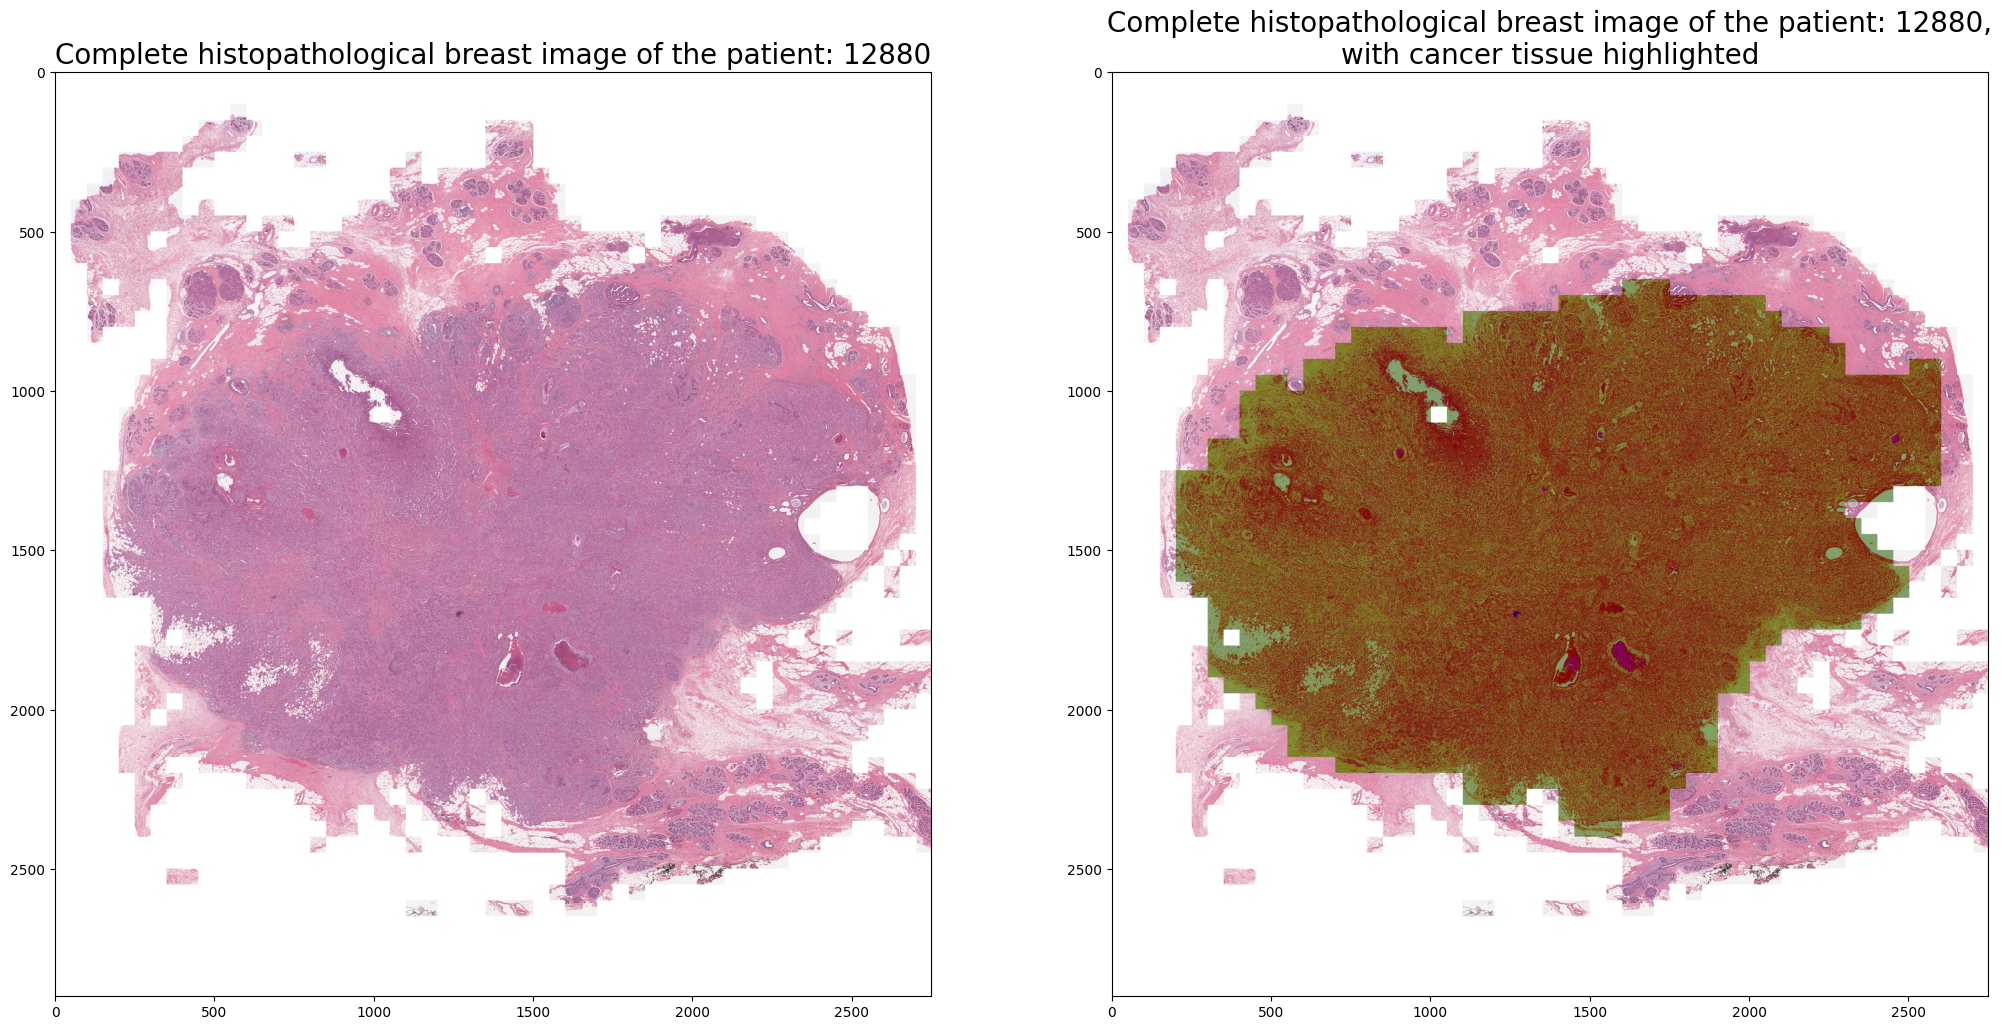

In [16]:
#Plot the full histopathological image of breast tissue of patient "12880"
patient_id = "12880"
#Get Histopathological Image of breast of patient "12880"
histopathological_img, mask = get_full_Histopathological_image_of_breast(patient_id)
#Perform bitwise AND operation using OpenCV to combine the 
# "mask", that highlights the cancer tissues in green, with "histopathological_img"
masked = cv2.bitwise_and(histopathological_img,mask)

#Plot the images
fig, ax = plt.subplots(1,2,figsize=(25,12))
ax[0].imshow(histopathological_img)
ax[0].set_title(f"Complete histopathological breast image of the patient: {patient_id}")
ax[0].title.set_size(20)

ax[1].imshow(masked)
ax[1].set_title(f"Complete histopathological breast image of the patient: {patient_id},\nwith cancer tissue highlighted");
ax[1].title.set_size(20)

**The green highlighted part shows the cancer tissues**

## Preprocessing

We will create dataset for:

- Training
- Validation
- Testing

We will create a new directory that will store random images. The directory structure will be like the following.


```
├── new_dataset
    ├── training
        ├── 0
            ├── 10253_idx5_x1001_y1001_class0.png
            ├── 10253_idx5_x1001_y1051_class0.png
            .
            .
            └── 10253_idx5_x1001_y1251_class0.png
        └── 1
            ├── 10253_idx5_x501_y351_class1.png
            ├── 10253_idx5_x501_y401_class1.png
            .
            .
            └── 10253_idx5_x551_y401_class1.png

    └── testing
        ├── 0
            ├── 10253_idx5_x1001_y1001_class0.png
            ├── 10253_idx5_x1001_y1051_class0.png
            .
            .
            └── 10253_idx5_x1001_y1251_class0.png
        └── 1
            ├── 10253_idx5_x501_y351_class1.png
            ├── 10253_idx5_x501_y401_class1.png
            .
            .
            └── 10253_idx5_x551_y401_class1.png

```

In [17]:
#Create "new dataset" directory
!mkdir new_dataset

In [18]:
#List all the file
!ls

breast-histopathology-images.zip  dataset  new_dataset	sample_data


In [19]:
"""
This function returns two lists containing the paths
of all the images of class 0 and class 1.
"""

def get_image_path_list():
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0),random.shuffle(c_0)
        random.shuffle(c_1),random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0),random.shuffle(class_0)
        random.shuffle(class_1),random.shuffle(class_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1

In [20]:
"""
This function accepts the "train_split" value from the range [0,1]
and based on that, splits the images into training and testing directories
for model training and evaluation.

"""

def create_dataset(train_split=0.85):
    #Use the "get_image_path_list" function to get two separate lists
    # of all the images of class 0 and class 1
    class0, class1 = get_image_path_list()

    #Shuffle the paths lists randomly
    random.shuffle(class0), random.shuffle(class0)
    random.shuffle(class1), random.shuffle(class1)

    #Calculate the total number of images of both classes
    total_img0 = len(class0)
    total_img1 = len(class1)

    #Calculate the number of images for train dataset for both classes
    train0_thresh = int(total_img0 * train_split)
    train1_thresh = int(total_img1 * train_split)

    #Create sub-directories for train directory
    train0_dir = "/content/new_dataset/train/0"
    train1_dir = "/content/new_dataset/train/1"
    os.makedirs(train0_dir)
    os.mkdir(train1_dir)

    #Create sub-directories for test directory
    test0_dir = "/content/new_dataset/test/0"
    test1_dir = "/content/new_dataset/test/1"
    os.makedirs(test0_dir)
    os.mkdir(test1_dir)

    #Let's copy the image of class 0
    for i in range(total_img0):
        path = class0[i]
        #If the index of the current image is less then the
        # validation threshold then, we'll copy the image to
        # the train directory, otherwise to the test directory
        if i < train0_thresh:
            shutil.copy(src=path, dst= train0_dir)
        else:
            shutil.copy(src=path, dst= test0_dir)
    
        #Let's copy the image of class 1
        
    for i in range(total_img1):
        path = class1[i]
        #If the index of the current image is less then the
        # validation threshold then, we'll copy the image to
        # the train directory, otherwise to the test directory
        if i < train1_thresh:
            shutil.copy(src=path, dst= train1_dir)
        else:
            shutil.copy(src=path, dst= test1_dir)


In [21]:
#Create the dataset using the function create_dataset()
# with 80% data for training and 20% for testing
create_dataset(train_split=0.80)

In [22]:
"""
If you run the create_dataset() function more than once, the os.makedirs() 
will generate "FileExistsError". So, to tackle that problem, you need to
either:
1)   comment the os.makedirs() in the create_dataset() function, or
2)   delete the created folders using the following commands
     and make the parent directory again
        !rm -rf "/content/new_dataset"
        !mkdir new_dataset
3)   or, use the if-else condition.
     if not(os.path.exists(path) and os.path.isdir(path)):
         os.makedirs(path)
I have not implemented the 3rd method because it makes the code lengthy and
difficult to understand and reuse. I used the second method.
"""

'\nIf you run the create_dataset() function more than once, the os.makedirs() \nwill generate "FileExistsError". So, to tackle that problem, you need to\neither:\n1)   comment the os.makedirs() in the create_dataset() function, or\n2)   delete the created folders using the following commands\n     and make the parent directory again\n        !rm -rf "/content/new_dataset"\n        !mkdir new_dataset\n3)   or, use the if-else condition.\n     if not(os.path.exists(path) and os.path.isdir(path)):\n         os.makedirs(path)\nI have not implemented the 3rd method because it makes the code lengthy and\ndifficult to understand and reuse. I used the second method.\n'

In [22]:
#To ensure that our function worked correctly, we can check the 
# size of training dataset
class0, class1 = get_image_path_list()

print("Size of 80% images of class 0 =", int(len(class0)*0.80))
print("Size of 80% images of class 1 =", int(len(class1)*0.80))
print("Size of 80% images of class both classes =", int(len(class1)*0.80) + int(len(class0)*0.80))

train_data_size = glob.glob("/content/new_dataset/train/**/*.png")
print("Size of training dataset =",len(train_data_size))

Size of 80% images of class 0 = 158990
Size of 80% images of class 1 = 63028
Size of 80% images of class both classes = 222018
Size of training dataset = 222018


Since both sizes are same, it proves that our function worked correctly. Moreover, our dataset has been created perfectly.

## Read the images from memory

To read the images, we'll use **image_dataset_from_directory** utility of TensofFlow. Moreover, since our dataset is small, so it would definitely **overfit**. To combat this overfitting, we'll use the **data augmentation** and **dropout** layers as well.

In [23]:
image_size = (50,50)
batch_size = 32

#Get "tensorflow.data.Dataset" object for the training data
train_dataset = image_dataset_from_directory(
    "/content/new_dataset/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

#Get "tensorflow.data.Dataset" object for the validation data
validation_dataset =image_dataset_from_directory(
    "/content/new_dataset/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 222018 files belonging to 2 classes.
Using 177615 files for training.
Found 222018 files belonging to 2 classes.
Using 44403 files for validation.


In [24]:
#Get "tensorflow.data.Dataset" object for the test data
test_dataset = image_dataset_from_directory(
    "/content/new_dataset/test",
    labels = "inferred",
    label_mode = 'int',
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 55506 files belonging to 2 classes.


## Building the model

To create the architecture of our model, we'll use the Keras Functional API.

In [25]:
#Create data augmentation layer using sequential model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3)
    ]   
)

In [26]:
#Define the model with data augmentation and dropout layers for
# combating overfitting
inputs = keras.Input(shape=(50, 50, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
#Since the image size is very small (50x50), so we are starting with
# large number for "filters". Usually, we start with small value
# and gradually increase. But here, we are diverging from
# our normal architecture due to small image size. Because,
# after the first layer, our image will reduce to (24x24)
# and most of the information in the image will be lost.
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 50, 50, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 256)       6912      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 256)       0         
                                                             

In [28]:
#Save the model summary to a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [29]:
#Compile the model
model.compile(loss="binary_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [30]:
#Callbacks
callbacks = [
            #keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
            keras.callbacks.ModelCheckpoint(filepath="CanDetect.keras",
                                            save_best_only=True,
                                            monitor="val_loss")
            ]

In [31]:
#Train the model
history = model.fit(
                    train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks
                   )

Epoch 1/20
5551/5551 [==============================] - 334s 57ms/step - loss: 0.3698 - accuracy: 0.8439 - val_loss: 0.4573 - val_accuracy: 0.7983
Epoch 2/20
5551/5551 [==============================] - 321s 58ms/step - loss: 0.3385 - accuracy: 0.8568 - val_loss: 0.3434 - val_accuracy: 0.8584
Epoch 3/20
5551/5551 [==============================] - 321s 58ms/step - loss: 0.3285 - accuracy: 0.8618 - val_loss: 0.5346 - val_accuracy: 0.7265
Epoch 4/20
5551/5551 [==============================] - 320s 58ms/step - loss: 0.3236 - accuracy: 0.8654 - val_loss: 0.4354 - val_accuracy: 0.8069
Epoch 5/20
5551/5551 [==============================] - 320s 58ms/step - loss: 0.3198 - accuracy: 0.8672 - val_loss: 0.3197 - val_accuracy: 0.8638
Epoch 6/20
5551/5551 [==============================] - 340s 61ms/step - loss: 0.3146 - accuracy: 0.8700 - val_loss: 0.4122 - val_accuracy: 0.7924
Epoch 7/20
5551/5551 [==============================] - 339s 61ms/step - loss: 0.3071 - accuracy: 0.8730 - val_loss: 0

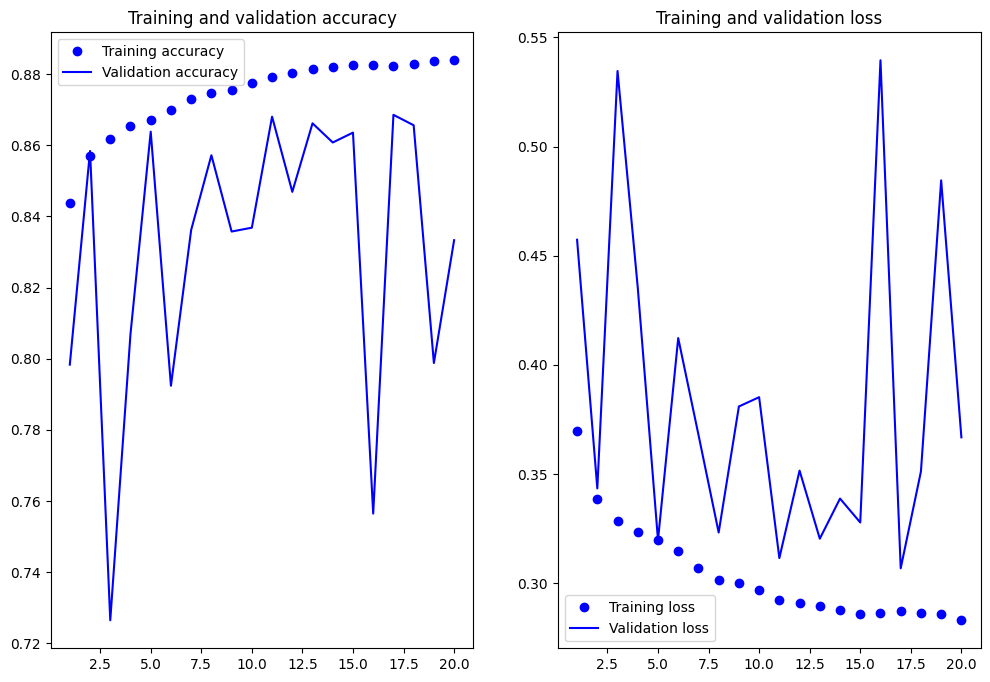

In [32]:
#plots of training and validation loss and accuracy

#Get the required values for plotting
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
fig, ax = plt.subplots(1,2,figsize=(12,8))

ax[0].plot(epochs, accuracy, "bo", label="Training accuracy")
ax[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax[0].set_title("Training and validation accuracy")
ax[0].legend()

ax[1].plot(epochs, loss, "bo", label="Training loss")
ax[1].plot(epochs, val_loss, "b", label="Validation loss")
ax[1].set_title("Training and validation loss")
ax[1].legend()

In [33]:
#Evaluating the model on the test set
test_model = keras.models.load_model("/content/CanDetect.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1735/1735 [==============================] - 40s 23ms/step - loss: 0.3097 - accuracy: 0.8719
Test accuracy: 0.872


## Confusion Matrix

In [34]:
"""
This function makes predictions on the test data. It returns
two lists containing the true class value and predicted class
value
"""
def test_the_model():
  class_true = []
  class_pred = []

  for batch_data, batch_labels in test_dataset:
      
      #Make predictions
      pred_labels = test_model.predict(batch_data)
      
      #Convert the NumPy ndarray object to simple list
      pred_labels_np = [float(i) for i in pred_labels]

      # Convert "tf.data.Dataset" to NumPy array
      batch_labels_np = tfds.as_numpy(batch_labels)

      #Append the true and predicted labels to their respective list
      class_true.extend(batch_labels_np)
      class_pred.extend(pred_labels_np)
  return class_true, class_pred

In [35]:
#Get the true and predicted class values
class_true, class_pred = test_the_model()

1/1 [==============================] - 0s 125ms/step


In [36]:
#Convert the predicted float values into integer values
class_pred_int = [round(i) for i in class_pred]

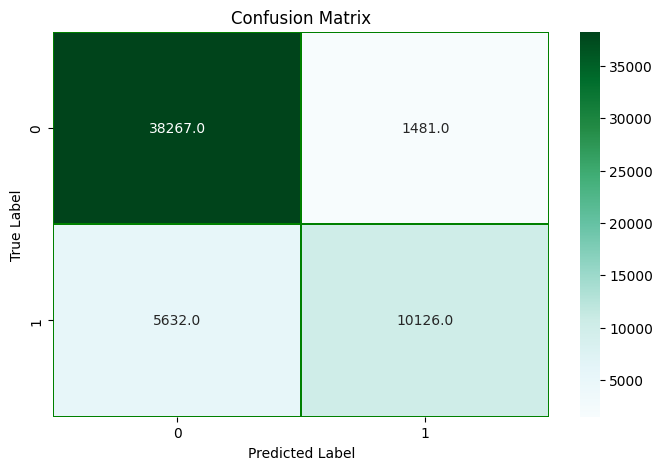

In [37]:
#Plot the confusion matrix
confusion = confusion_matrix(class_true, class_pred_int)
fig,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion, annot=True, linewidths=0.1,
            cmap="BuGn", linecolor="green", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

ROC AUC score =0.803


Text(0, 0.5, 'True Positive Rate')

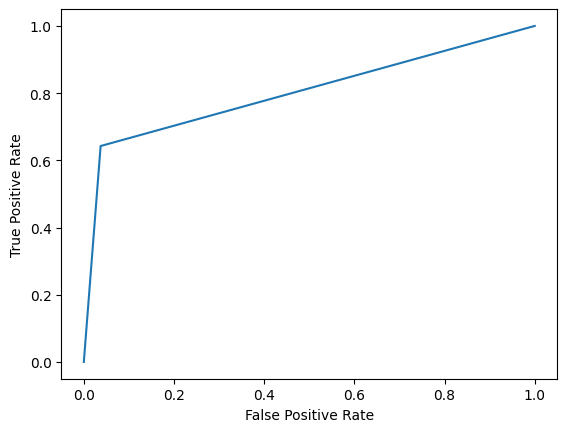

In [39]:
#Calculate ROC scores
ROC_AUC = roc_auc_score(class_true, class_pred_int)
# summarize scores
print('ROC AUC score =%.3f' % (ROC_AUC))

#Calculate roc curves
fpr, tpr, thresholds = roc_curve(class_true, class_pred_int)

#Plot the roc curve
plt.plot(fpr, tpr,label="AUC="+str(ROC_AUC))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')